Sentence Tranformer Model

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sentence_transformers import SentenceTransformer, util
import joblib

We load the GDPR json and flatten the structure of the json to get a dataframe

In [31]:
with open('../gdpr_articles_baseline.json', 'r', encoding='utf-8') as f:
    gdpr_data = json.load(f)

# Flatten the structure
flattened = []
for article in gdpr_data:
    for section in article['sections']:
        for sec_num, sec_text in section.items():
            flattened.append({
                "article_number": article['article_number'],
                "article_title": article['article_title'],
                "section_number": sec_num,
                "section_text": sec_text
            })

gdpr_df = pd.DataFrame(flattened)
gdpr_df.head()

,article_number,article_title,section_number,section_text
0,1,Subject-matter and objectives,1.,This Regulation lays down rules relating to th...
1,1,Subject-matter and objectives,2.,This Regulation protects fundamental rights an...
2,1,Subject-matter and objectives,3.,The free movement of personal data within the ...
3,2,Material scope,1.,This Regulation applies to the processing of p...
4,2,Material scope,2.,This Regulation does not apply to the processi...


We have only focused on GDPR articles 5-7

In [32]:
# Filtering only articles 5-7 
#gdpr_df = gdpr_df.loc[gdpr_df['article_number'].isin([5, 6, 7])]
gdpr_df

,article_number,article_title,section_number,section_text
0,1,Subject-matter and objectives,1.,This Regulation lays down rules relating to th...
1,1,Subject-matter and objectives,2.,This Regulation protects fundamental rights an...
2,1,Subject-matter and objectives,3.,The free movement of personal data within the ...
3,2,Material scope,1.,This Regulation applies to the processing of p...
4,2,Material scope,2.,This Regulation does not apply to the processi...
...,...,...,...,...
761,97,Commission reports,6.,In carrying out the evaluations and reviews re...
762,97,Commission reports,7.,"The Commission shall, if necessary, submit app..."
763,98,Review of other Union legal acts on data prote...,1.,"1\nThe Commission shall, if appropriate, submi..."
764,99,Entry into force and application,1.,This Regulation shall enter into force on the ...


Load the privacy policy as dataframe

In [33]:
with open("../ikea_privacy_policy.json", encoding="utf-8") as f:
    ikea_data = json.load(f)

ikea_df = pd.DataFrame(ikea_data)
ikea_df

,section_title,section_text
0,1. Who is the responsible controller for the d...,The party responsible for processing data (“co...
1,2. What data is being processed and from which...,We process the data that we receive from you i...
2,3. For which purpose and for how long is the d...,We process your data for specific purposes an...
3,4. On which legal basis is personal data being...,4.1 On grounds of consent – Art 6 para 1 lit a...
4,5. Who will be receiving your data?,Your data will be passed on to the following r...
5,6. Are you obliged to provide data?,You will need to give us your data for us to b...
6,7. Is there automated decision-making includin...,We will not use automated decision-making acco...
7,8. Your rights in processing your personal data,You may (i) demand disclosure on whether and w...


We load the Sentence Tranformer model and create the embeddings for the privacy policy and GDPR law

In [34]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [35]:
ikea_embeddings = model.encode(ikea_df["section_text"].tolist(), convert_to_tensor=True)
gdpr_embeddings = model.encode(gdpr_df["section_text"].tolist(), convert_to_tensor=True)


We find the cosine similarity between the embeddings and build a similarity dataframe

In [36]:
cos_sim_matrix = util.cos_sim(ikea_embeddings, gdpr_embeddings).cpu().numpy()

# Build similarity DataFrame
sim_df = pd.DataFrame(
    cos_sim_matrix,
    index=ikea_df["section_title"],
    columns=[f"Art. {row.article_number}-{row.section_number}" for _, row in gdpr_df.iterrows()]
)


In [37]:
sim_df

,Art. 1-1.,Art. 1-2.,Art. 1-3.,Art. 2-1.,Art. 2-2.,Art. 2-3.,Art. 2-4.,Art. 2-5.,Art. 2-6.,Art. 2-7.,...,Art. 97-1.,Art. 97-2.,Art. 97-3.,Art. 97-4.,Art. 97-5.,Art. 97-6.,Art. 97-7.,Art. 98-1.,Art. 99-1.,Art. 99-2.
section_title,,,,,,,,,,,,,,,,,,,,,
1. Who is the responsible controller for the data processing and whom you may contact?,0.162239,0.138440,0.173913,0.157947,0.158318,0.002596,0.017820,0.014924,0.112665,0.245714,...,0.169374,0.227415,0.233397,0.029259,0.233247,0.129014,0.102292,0.268311,0.024750,0.132082
2. What data is being processed and from which sources do these stem from?,0.275349,0.268754,0.236350,0.294850,0.240337,0.052118,0.079494,0.188643,0.065110,0.384741,...,0.146225,0.283515,0.330562,0.008930,0.213215,0.123777,0.090196,0.317487,0.005115,0.067736
3. For which purpose and for how long is the data being processed?,0.523394,0.502780,0.384324,0.606330,0.523263,0.182311,0.225657,0.149772,0.327867,0.534368,...,0.355892,0.408968,0.489166,0.035080,0.379133,0.261555,0.270858,0.489706,0.238613,0.231427
4. On which legal basis is personal data being processed?,0.527387,0.445803,0.456854,0.488921,0.447070,0.149796,0.159165,0.099024,0.238873,0.459231,...,0.260915,0.434715,0.481395,0.129251,0.353099,0.209408,0.362479,0.566780,0.281327,0.145696
5. Who will be receiving your data?,0.331831,0.358036,0.316935,0.324435,0.310459,0.163416,0.073824,0.057707,0.213072,0.446617,...,0.181093,0.381871,0.445408,0.027278,0.320794,0.213925,0.166342,0.438685,0.110509,0.105028
6. Are you obliged to provide data?,0.291595,0.281384,0.277930,0.253308,0.254942,0.091190,0.108053,0.136749,0.103993,0.296590,...,0.102922,0.227426,0.264205,-0.000131,0.221782,0.104060,0.136653,0.289707,0.045263,0.077629
7. Is there automated decision-making including profiling?,0.328425,0.211042,0.286754,0.392426,0.352282,0.110018,0.121463,0.154004,0.101219,0.370583,...,0.236458,0.366474,0.400943,0.213442,0.181935,0.119172,0.285608,0.386407,0.247261,0.193693
8. Your rights in processing your personal data,0.501874,0.471188,0.477326,0.433671,0.429333,0.131112,0.085894,0.023748,0.189899,0.533417,...,0.269280,0.482694,0.574196,0.132112,0.332431,0.194819,0.228168,0.513398,0.205550,0.160011


In [38]:
ikea_df = ikea_df.reset_index(drop=True)
sim_df = sim_df.reset_index(drop=True)

We finally get the most similar matches from the GDPR law for the privacy poicy sections

In [39]:
ikea_df["semantic_similarity_score"] = sim_df.max(axis=1)
ikea_df["best_match_gdpr_section"] = sim_df.idxmax(axis=1)


In [44]:
ikea_df["section_index"] = ikea_df['section_title'].str.extract(r'^(\d+)\.')
ikea_df["article_number"] = ikea_df["best_match_gdpr_section"].str.extract(r'Art\.\s*(\d+)').astype(int)
ikea_df

,section_title,section_text,semantic_similarity_score,best_match_gdpr_section,section_index,article_number
0,1. Who is the responsible controller for the d...,The party responsible for processing data (“co...,0.395234,Art. 28-8.,1,28
1,2. What data is being processed and from which...,We process the data that we receive from you i...,0.435829,Art. 17-7.,2,17
2,3. For which purpose and for how long is the d...,We process your data for specific purposes an...,0.724845,Art. 13-4.,3,13
3,4. On which legal basis is personal data being...,4.1 On grounds of consent – Art 6 para 1 lit a...,0.680315,Art. 13-8.,4,13
4,5. Who will be receiving your data?,Your data will be passed on to the following r...,0.551923,Art. 28-4.,5,28
5,6. Are you obliged to provide data?,You will need to give us your data for us to b...,0.478245,Art. 13-13.,6,13
6,7. Is there automated decision-making includin...,We will not use automated decision-making acco...,0.533712,Art. 13-14.,7,13
7,8. Your rights in processing your personal data,You may (i) demand disclosure on whether and w...,0.630401,Art. 50-3.,8,50


In [45]:
report = []
article_lookup = dict(zip(gdpr_df["article_number"], gdpr_df["article_title"]))
for idx, row in ikea_df.iterrows():
    
    section_title = row["section_title"]
    section_index = row["section_index"]
    article_number = row["article_number"]
    article_title = article_lookup.get(article_number, "Unknown Article")

    top_matches = [{
        "article": article_number,
        "title": article_title,
        "similarity": float(row["semantic_similarity_score"])
    }]

    # Append the structured dictionary to report
    report.append({
        "section_index": section_index,
        "section_title": section_title,
        "top_matches": top_matches
    })
print(json.dumps(report, indent=2, ensure_ascii=False))
with open("../results/ikea_sentenceTransformer.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print(ikea_df[["section_title", "semantic_similarity_score", "best_match_gdpr_section"]].sort_values(by="semantic_similarity_score", ascending=False))

[
  {
    "section_index": "1",
    "section_title": "1. Who is the responsible controller for the data processing and whom you may contact?",
    "top_matches": [
      {
        "article": 28,
        "title": "Processor",
        "similarity": 0.39523419737815857
      }
    ]
  },
  {
    "section_index": "2",
    "section_title": "2. What data is being processed and from which sources do these stem from?",
    "top_matches": [
      {
        "article": 17,
        "title": "Right to erasure (‘right to be forgotten’)",
        "similarity": 0.4358285665512085
      }
    ]
  },
  {
    "section_index": "3",
    "section_title": "3. For which purpose and for how long is the data being processed?",
    "top_matches": [
      {
        "article": 13,
        "title": "Information to be provided where personal data are collected from the data subject",
        "similarity": 0.7248451709747314
      }
    ]
  },
  {
    "section_index": "4",
    "section_title": "4. On which legal basi

In [42]:
joblib.dump(model, "../streamlit/sentence_transformer_model.joblib")

['../streamlit/sentence_transformer_model.joblib']

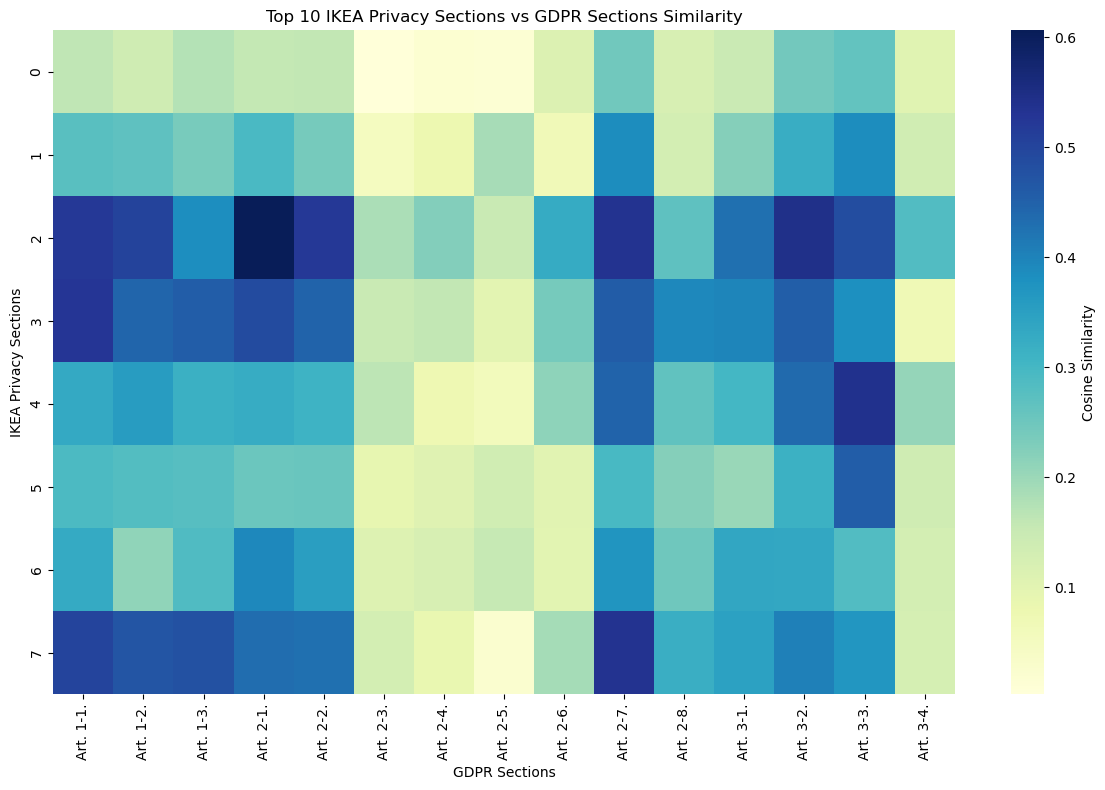

In [43]:
# Similarity matrix for top 10 IKEA sections
plt.figure(figsize=(12, 8))
sns.heatmap(sim_df.iloc[:10, :15], cmap="YlGnBu", cbar_kws={'label': 'Cosine Similarity'})
plt.title("Top 10 IKEA Privacy Sections vs GDPR Sections Similarity")
plt.xlabel("GDPR Sections")
plt.ylabel("IKEA Privacy Sections")
plt.tight_layout()
plt.show()